# Generative Adversarial Networks

Generative Adversarial Networks are composed of two networks, namely Generative (G) and Discriminative (D), that "fight" against each other with the following objectives:
* G: fool D into saying its data is real
* D: discriminate G correctly from true data, such that G is classified as fake

## Exercise: Transform a square into a circle

In this exercise a set of training points sampled from a uniform distribution (the prior of G) must be mapped into a Gaussian distribution (real data pdf). We will make it happen (as close as possible for a certain amount of epochs) through a Generative Adversarial Network.

pdf shape:  (5000, 2)


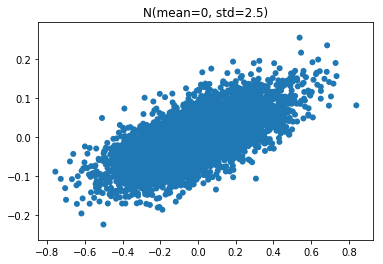

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
# import required layers
from tensorflow.contrib.layers import fully_connected, xavier_initializer
from scipy.stats import norm
import timeit
from IPython import display as dp

# create n_samples sampled from 2D N(0, 2.5)
n_samples = 5000
cov_mat = 0.01 * np.eye(2) + [[0., 0.0], [0.05, 0.]]
#pdf_x = np.random.multivariate_normal(np.zeros(2), 0.01 * np.eye(2), n_samples)
pdf_x = np.random.multivariate_normal(np.zeros(2), cov_mat, n_samples)
print "pdf shape: ", pdf_x.shape
_ = plt.scatter(pdf_x[:, 0], pdf_x[:, 1], edgecolor='none')
_ = plt.title('N(mean=0, std=2.5)')

In [2]:
# define leakyrelu activation
def leakyrelu(x, alpha=0.3):
    return tf.maximum(x, alpha * x)

**Exercise:** Define the Generator network (G) by observing the architecture of D (defined right below) and mirroring it to go from random vector $z$ to synthetic samples.

In [3]:
# Define the Generator network
def generator(z, out_dim=2, n_hidden=128, n_layers=2):
    # TODO: MLP with n_layers hidden layers, each of n_hidden units
    # This network maps z (withdrawn from prior distribution) to the pdf in train data
    with tf.variable_scope('generator') as scope:
        hi = z
        for h_idx in range(n_layers):
            # make them tanh layers
            hi = fully_connected(hi, n_hidden, activation_fn=None,
                                 weights_initializer=tf.orthogonal_initializer(gain=1.4))
            hi = leakyrelu(hi)
        # output layer
        x = fully_connected(hi, out_dim, activation_fn=None,
                            weights_initializer=tf.orthogonal_initializer(gain=1.4))
    return x

In [4]:
# Define the Discriminator network
def discriminator(x, n_hidden=128, n_layers=2, reuse=False):
    # MLP with n_layers hidden layers, each of n_hidden units
    # This network classifies whether x is real (1) or fake (0) with a logistic regression output
    with tf.variable_scope('discriminator') as scope:
        if reuse:
            scope.reuse_variables()
        hi = x
        for h_idx in range(n_layers):
            # make them tanh layers
            hi = fully_connected(hi, n_hidden, activation_fn=tf.tanh,
                                 weights_initializer=tf.orthogonal_initializer(gain=1.4))
        # output layer
        logit = fully_connected(hi, 1, activation_fn=None,
                                weights_initializer=tf.orthogonal_initializer(gain=1.4))
    return logit, tf.nn.sigmoid(logit)

In [12]:
# Define the params to be used. TUNE THIS TO CHANGE TRAINING BEHAVIOR
params = dict(batch_size=100,
              d_learning_rate=0.0002,
              g_learning_rate=0.0002,
              beta_1=0.5,
              num_epochs=40,
              viz_every=100,
              z_dim=100,
              z_prior=np.random.uniform,
              x_dim=2,
              d_iters=8, # num of d updates before g is updated
              g_hidden_layers=2,
              d_hidden_layers=2,
              g_hidden_size=256,
              d_hidden_size=256)
    

In [13]:
tf.reset_default_graph()
# Construct the models and training ops
# define the prior placeholder (to be fed during training)
z = tf.placeholder(tf.float32, [None, params['z_dim']])
x_real = tf.placeholder(tf.float32, [params['batch_size'], params['x_dim']])
# get Generator ops
G = generator(z, params['x_dim'], params['g_hidden_size'], params['g_hidden_layers'])
# get Discriminator ops on real data
D_rl_logit, D_rl = discriminator(x_real, params['d_hidden_size'], params['d_hidden_layers'])
# get Discriminator ops on fake data. The reuse=True specifies we reuse 
# the discriminator ops for this new input placeholder 
D_fk_logit, D_fk = discriminator(G, params['d_hidden_size'], params['d_hidden_layers'], reuse=True)

# D real loss
D_rl_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(D_rl_logit, tf.ones_like(D_rl_logit)))
# D fake loss: minimizes the divergence of D_fk_logit to 0 (fake)
D_fk_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(D_fk_logit, tf.zeros_like(D_fk_logit)))
# D loss as both
D_loss = D_rl_loss + D_fk_loss

# G loss: minimizes the divergence of D_fk_logit to 1 (real)
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(D_fk_logit, tf.ones_like(D_fk_logit)))

# get the training vars for both networks
t_vars = tf.trainable_variables()

D_vars = [var for var in t_vars if 'discriminator' in var.name]
G_vars = [var for var in t_vars if 'generator' in var.name]

# set up both optimizers to apply gradient descent w/ Adam
D_opt = tf.train.AdamOptimizer(params['d_learning_rate'], beta1=params['beta_1']).minimize(D_loss, var_list=D_vars)
G_opt = tf.train.AdamOptimizer(params['g_learning_rate'], beta1=params['beta_1']).minimize(G_loss, var_list=G_vars)


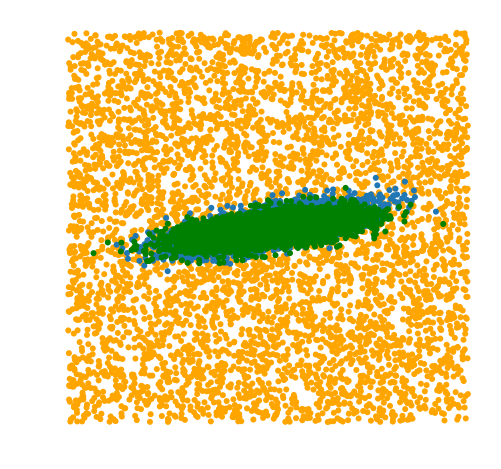

Done training for 40 epochs! Time lapsed: 63.7767572403s
Total amount of iterations done:  2000


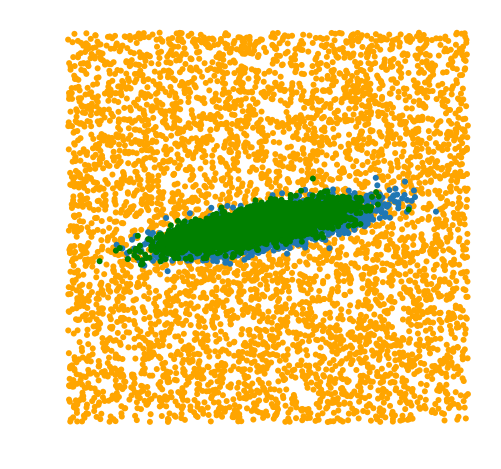

In [16]:
from tqdm import tqdm

# set up the TF session and init all ops and variables
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

# store resulting losses out of training
d_rl_losses = []
d_fk_losses = []
d_losses = []
g_losses = []

# Pick a big sample from z and project it through G and compare to pdf_x (original data pdf)
# this is not data to be trained on, but to check G projections
sample_z = params['z_prior'](-1, 1, [n_samples, params['z_dim']]).astype(np.float32)
batches_per_epoch = pdf_x.shape[0] / params['batch_size']
counter = 0
curr_epoch = -1
batch_timings = []
frames = []

# activate interactive mode 
plt.ion()
# make the figure
fig = plt.figure(figsize=(8, 8))

#for counter in tqdm(xrange(params['num_epochs'] * batches_per_epoch)):
for counter in xrange(params['num_epochs'] * batches_per_epoch):
    if counter % batches_per_epoch == 0:
        # epoch change. First time this if is true, so also init variables.
        batch_idx = 0
        curr_epoch += 1
        # randomize the pdf_x samples
        np.random.shuffle(pdf_x)
    beg_t = timeit.default_timer()
    # sample a batch from prior pdf z
    batch_z = params['z_prior'](-1, 1, [params['batch_size'], params['z_dim']]).astype(np.float32)
    # get a batch of samples from gtruth pdf
    batch_x_real = pdf_x[batch_idx:(batch_idx + params['batch_size'])]
    # define the feeding placeholders
    d_feed_dict = {z:batch_z, x_real:batch_x_real}
    g_feed_dict = {z:batch_z}
    # run D update
    for _ in range(params['d_iters']):
        _, D_rl_trloss, D_fk_trloss, D_trloss = sess.run([D_opt, D_rl_loss, D_fk_loss, D_loss], 
                                                         feed_dict=d_feed_dict)
    # run G update
    _, G_trloss = sess.run([G_opt, G_loss], feed_dict=g_feed_dict)
    d_rl_losses.append(D_rl_trloss)
    d_fk_losses.append(D_fk_trloss)
    d_losses.append(D_trloss)
    g_losses.append(G_trloss)
    end_t = timeit.default_timer()
    batch_timings.append(end_t - beg_t)
    if counter % params['viz_every'] == 0:
        #print "batch {:3d}/{:3d} (epoch {:3d}/{:3d}), D_fk_loss = {:.4f}" \
        #      ", D_loss = {:.4f}, G_loss = {:.4f}, " \
        #      "mtime/batch = {:.4f}s".format(batch_idx + 1, batches_per_epoch, 
        #                                     curr_epoch + 1, params['num_epochs'], D_fk_trloss, 
        #                                     D_rl_trloss, D_trloss, G_trloss, np.mean(batch_timings))
        
        fake_pred = sess.run(G, feed_dict={z:sample_z})
        dp.clear_output(wait=True)
        dp.display(plt.gcf())
        plt.cla()
        ax = plt.scatter(sample_z[:, 0], sample_z[:, 1], edgecolor='none', color='orange')
        ax = plt.scatter(pdf_x[:, 0], pdf_x[:, 1], edgecolor='none')
        ax = plt.scatter(fake_pred[:, 0], fake_pred[:, 1], color='green', edgecolor='none')
        plt.axis('off')
    counter += 1
    batch_idx += 1
print "Done training for {} epochs! Time lapsed: {}s".format(params['num_epochs'], np.sum(batch_timings))
print "Total amount of iterations done: ", counter

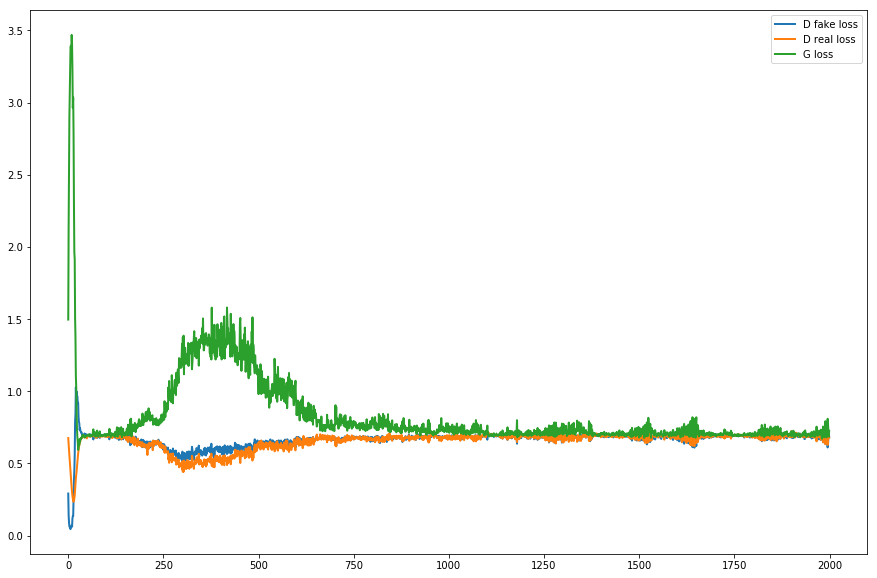

In [17]:
# Visualize the learning curves (let's see the funny behavior of GANs in action!)
_= plt.figure(figsize=(15, 10))
_ = plt.plot(d_fk_losses, label='D fake loss', linewidth=2.)
_ = plt.plot(d_rl_losses, label='D real loss', linewidth=2.)
#plt.plot(d_losses, label='D loss')
_ = plt.plot(g_losses, label='G loss', linewidth=2.)
_ = plt.legend()
# NOTE: there is no optimization towards a minima! Instead they are very noisy and paired to each other!

Inferred 5000 G samples in 0.00373005867004 s


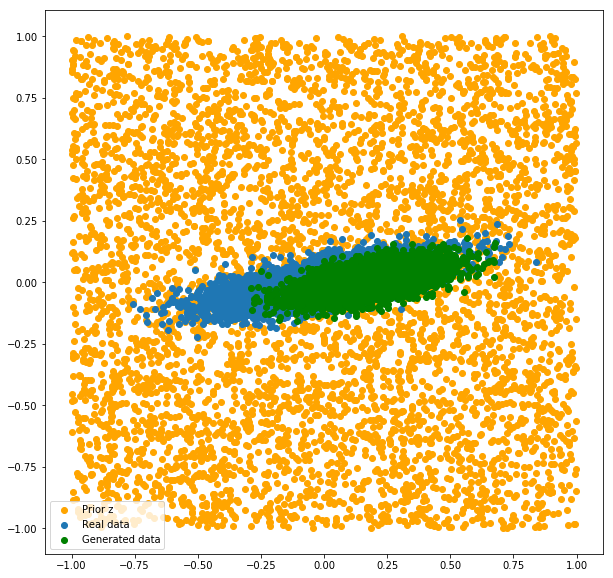

In [11]:
beg_t = timeit.default_timer()
fake_pred = sess.run(G, feed_dict={z:sample_z})
end_t = timeit.default_timer()
print "Inferred {} G samples in {} s".format(n_samples, end_t - beg_t)
_ = plt.figure(figsize=(10, 10))
_ = plt.scatter(sample_z[:, 0], sample_z[:, 1], color='orange', label='Prior z')
_ = plt.scatter(pdf_x[:, 0], pdf_x[:, 1], label='Real data')
_ = plt.scatter(fake_pred[:, 0], fake_pred[:, 1], color='green', label='Generated data')
_ = plt.legend()